In [1]:
import re
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import Word
import joblib

#Import library for tokeize, stemming, and stopwords
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwords_scratch
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Import library for Tensorflow Model Sentiment Analysis
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from keras.layers import Embedding

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('data/train_preprocess.tsv', sep='\t', names=['Text', 'Sentiment'])
df.head()

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


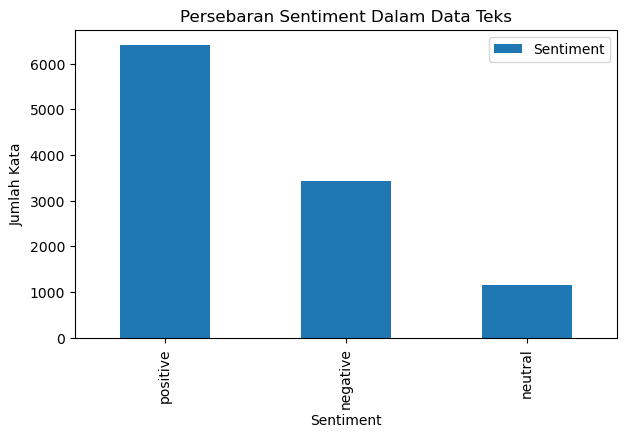

In [3]:
df['Sentiment'].value_counts().plot.bar(figsize= (7,4))
plt.title('Persebaran Sentiment Dalam Data Teks')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()

In [4]:
mapping = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}

df['label_val'] = df['Sentiment'].replace(mapping)
df['panjang_text'] = df['Text'].str.len()
df.head()

,Text,Sentiment,label_val,panjang_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,2,404
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,1,102
2,lokasi strategis di jalan sumatera bandung . t...,positive,2,184
3,betapa bahagia nya diri ini saat unboxing pake...,positive,2,93
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,0,214


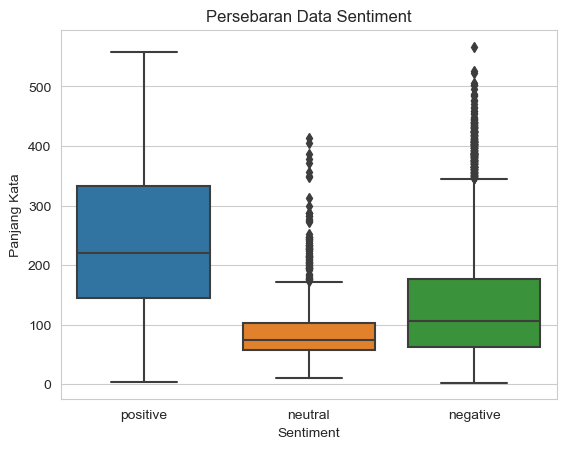

In [5]:
#visualisasi dengan box plot
import seaborn as sns
sns.set_style('whitegrid')
sns.boxplot(y = df['panjang_text'], x = df['Sentiment'])
plt.ylabel('Panjang Kata')
plt.title('Persebaran Data Sentiment')
plt.show()

In [6]:
#Pesebaran data dengan standar deviasi dan visualisasi
print(df['label_val'].describe(include=['all']))

count    11000.000000
mean         1.270909
std          0.906818
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: label_val, dtype: float64


In [7]:
print('Data Distribution')
print('mean: ', df['label_val'].mean())
print('variance: ', df['label_val'].var())
print('standar deviation: ', df['label_val'].std())

Data Distribution
mean:  1.270909090909091
variance:  0.822319384406795
standar deviation:  0.9068182752937851


In [8]:
#kamus alay
df_alay = pd.read_csv('data/new_kamusalay.csv', names=['alay', 'cleaned'], encoding='latin-1')
df_alay.head()

,alay,cleaned
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [9]:
#Create Stopwords
list_stopwords = stopwords_scratch.words('indonesian')
list_stopwords_en = stopwords_scratch.words('english')
list_stopwords.extend(list_stopwords_en)
list_stopwords.extend(['ya', 'yg', 'ga', 'yuk', 'dah', 'baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'])

#External stopwords
f = open('stopwords/tala-stopwords-indonesia.txt', 'r')
stopword_external = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_external.append(line_list[0])
f.close()
list_stopwords.extend(stopword_external)

stopwords = list_stopwords

In [10]:
#Creating Function for Cleansing Process
def lowercase(text):
    return text.lower()

def special(text):
    text = re.sub(r'\W', ' ', str(text), flags=re.MULTILINE)
    return text

def single(text):
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def singlestart(text):
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def mulspace(text):
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text

#Removing RT
def rt(text):
    text = re.sub(r'rt @\w+: ', ' ', text, flags=re.MULTILINE)
    return text

#Removing prefixed 'b'
def prefixedb(text):
    text = re.sub(r'^b\s+', '', text, flags=re.MULTILINE)
    return text

def misc(text):
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|([#@]\S+)|user|\n|\t', ' ', text, flags=re.MULTILINE)
    return text

#Mapping for kamusalay
alay_mapping = dict(zip(df_alay['alay'], df_alay['cleaned']))
def alay(text):
    wordlist = text.split()
    text_alay = [alay_mapping.get(x,x) for x in wordlist]
    clean_alay = ' '.join(text_alay)
    return clean_alay

# Stopwords fuction
def stopwrds(text): 
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    output_sw = ' '.join(tokens_without_sw)
    return output_sw

#Function for text cleansing
def cleansing(text):
    text = lowercase(text)
    text = special(text)
    text = singlestart(text)
    text = mulspace(text)
    text = rt(text)
    text = prefixedb(text)
    text = misc(text)
    text = alay(text)
    text = stopwrds(text)
    return text

In [11]:
text = df['Text'].apply(lambda x: cleansing(x))
text

0        warung dimiliki pengusaha pabrik puluhan terke...
1        mohon ulama lurus k212 mmbri hujjah partai diw...
2        lokasi strategis jalan sumatra bandung nya nya...
3        betapa bahagia nya unboxing paket barang nya b...
4        aduh mahasiswa sombong kasih kartu kuning bela...
                               ...                        
10995                                               kecewa
10996    enak masakan nya kepiting menyenangkan memilih...
10997                     hormati partai partai berkoalisi
10998      pagi pagi tol pasteur macet parah bikin jengkel
10999    belanja yogyakarta riau junction lihat foodlif...
Name: Text, Length: 11000, dtype: object

In [12]:
#Encoded the target column
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df['Sentiment'] = lb.fit_transform(df['Sentiment'])
df['Sentiment']

0        2
1        1
2        2
3        2
4        0
        ..
10995    2
10996    2
10997    1
10998    0
10999    2
Name: Sentiment, Length: 11000, dtype: int32

In [13]:
#Tokenizer
analisis = text.values
tokenizer = Tokenizer(num_words = 5000, split=' ')
tokenizer.fit_on_texts(analisis)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(analisis)
x = pad_sequences(encoded_docs, maxlen=200)

In [14]:
#Dump Tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

In [15]:
print(tokenizer.word_index)

{'nya': 1, 'enak': 2, 'makanan': 3, 'makan': 4, 'harga': 5, 'menu': 6, 'bandung': 7, 'banget': 8, 'restoran': 9, 'suasana': 10, 'malam': 11, 'nyaman': 12, 'jalan': 13, 'orang': 14, 'pelayanan': 15, 'ayam': 16, 'goreng': 17, 'suka': 18, 'bagus': 19, 'pemandangan': 20, 'nasi': 21, 'teman': 22, 'indonesia': 23, 'pilihan': 24, 'mahal': 25, 'sih': 26, 'lumayan': 27, 'kota': 28, 'cocok': 29, 'keluarga': 30, 'pas': 31, 'lokasi': 32, 'resto': 33, 'anak': 34, 'pesan': 35, 'porsi': 36, 'salah': 37, 'steak': 38, 'sunda': 39, 'minuman': 40, 'kafe': 41, 'khas': 42, 'rumah': 43, 'murah': 44, 'masakan': 45, 'mi': 46, 'ramah': 47, 'ramai': 48, 'bakso': 49, 'sambal': 50, 'oke': 51, 'favorit': 52, 'jam': 53, 'deh': 54, 'bakar': 55, 'menikmati': 56, 'mantap': 57, '2': 58, 'siang': 59, 'coba': 60, 'terjangkau': 61, 'partai': 62, 'mencoba': 63, 'daging': 64, '1': 65, 'bikin': 66, 'masuk': 67, 'luas': 68, 'cepat': 69, 'daerah': 70, 'memesan': 71, 'pedas': 72, 'jokowi': 73, 'pakai': 74, 'unik': 75, 'batagor'

In [16]:
#Evaluasi
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           500576    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 60)                22320     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 3)                 183       
                                                                 
Total params: 523,079
Trainable params: 523,079
Non-trainable params: 0
__________________________________________________

In [17]:
#training
from sklearn.model_selection import train_test_split

y = pd.get_dummies(df['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [18]:
#callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print('\nAkurasi telah mencapai nilai >95%!')
            self.model.stop_training = True
callbacks = myCallback()

In [19]:
batch_size = 32
history = model.fit(X_train, y_train, epochs = 50, batch_size= batch_size, validation_split=0.3, callbacks=[callbacks])

Epoch 1/50
169/169 [==============================] - 40s 208ms/step - loss: 0.4738 - accuracy: 0.6759 - val_loss: 0.3446 - val_accuracy: 0.7762
Epoch 2/50
169/169 [==============================] - 34s 201ms/step - loss: 0.3381 - accuracy: 0.7772 - val_loss: 0.3058 - val_accuracy: 0.7948
Epoch 3/50
169/169 [==============================] - 34s 200ms/step - loss: 0.2787 - accuracy: 0.8167 - val_loss: 0.2672 - val_accuracy: 0.8225
Epoch 4/50
169/169 [==============================] - 34s 201ms/step - loss: 0.2077 - accuracy: 0.8766 - val_loss: 0.2370 - val_accuracy: 0.8455
Epoch 5/50
169/169 [==============================] - 34s 200ms/step - loss: 0.1681 - accuracy: 0.9089 - val_loss: 0.2435 - val_accuracy: 0.8545
Epoch 6/50
169/169 [==============================] - 34s 200ms/step - loss: 0.1392 - accuracy: 0.9199 - val_loss: 0.2564 - val_accuracy: 0.8502
Epoch 7/50
169/169 [==============================] - 34s 200ms/step - loss: 0.1172 - accuracy: 0.9375 - val_loss: 0.2811 - val_ac

In [20]:
model.evaluate(X_test, y_test)

104/104 [==============================] - 3s 25ms/step - loss: 0.3673 - accuracy: 0.8321


[0.36729463934898376, 0.8321211934089661]

In [21]:
model.save('model.h5')

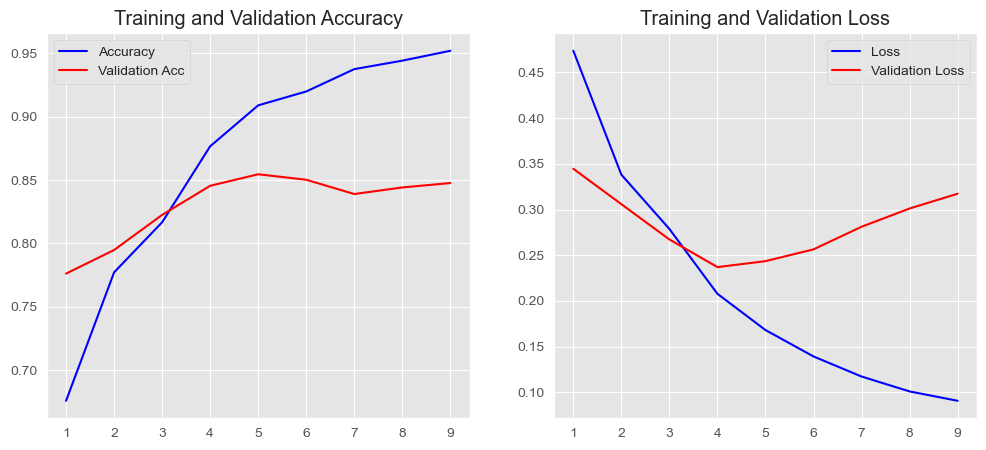

In [22]:
#memvisualisasikan hasil prediksi dan hasil loss
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc)+1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label= 'Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label= 'Loss')
    plt.plot(x, val_loss, 'r', label= 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [23]:
def predict_sentiment(text):
    sentiment_tf = ['negative', 'neutral', 'positive']
    text = cleansing(text)
    tos = tokenizer.texts_to_sequences([text])
    tos = pad_sequences(tos, maxlen=x.shape[1])
    prediction = model.predict(tos)
    polarity = np.argmax(prediction[0])
    return sentiment_tf[polarity]

In [24]:
output_tf = predict_sentiment('restorannya enak, tapi sayang pelayanannya jelek')
print(output_tf)

1/1 [==============================] - 0s 318ms/step
negative


In [25]:
y_test = y_test.values
y_pred = model.predict(X_test)
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix_test)

104/104 [==============================] - 3s 26ms/step
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1031
           1       0.78      0.58      0.67       342
           2       0.87      0.92      0.89      1927

    accuracy                           0.83      3300
   macro avg       0.81      0.75      0.77      3300
weighted avg       0.83      0.83      0.83      3300



In [26]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
y = y.values
accuracies = []

for iteration, data in enumerate(kf.split(x), start=1):
    data_train = x[data[0]]
    target_train = y[data[0]]
    
    data_test = x[data[1]]
    target_test = y[data[1]]
    
    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
    model.add(SpatialDropout1D(0.25))
    model.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    batch_size = 32
    history = model.fit(X_train, y_train, epochs = 50, batch_size = batch_size, validation_split=0.3, callbacks=[callbacks])
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    
    print('Training no: ', iteration)
    print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('==========================================================')
    
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print()
print('Average Accuracy: ', average_accuracy)

Epoch 1/50
169/169 [==============================] - 37s 199ms/step - loss: 0.4976 - accuracy: 0.6297 - val_loss: 0.3639 - val_accuracy: 0.7593
Epoch 2/50
169/169 [==============================] - 33s 195ms/step - loss: 0.3449 - accuracy: 0.7716 - val_loss: 0.3067 - val_accuracy: 0.7887
Epoch 3/50
169/169 [==============================] - 33s 194ms/step - loss: 0.2677 - accuracy: 0.8284 - val_loss: 0.2574 - val_accuracy: 0.8377
Epoch 4/50
169/169 [==============================] - 34s 202ms/step - loss: 0.2007 - accuracy: 0.8824 - val_loss: 0.2317 - val_accuracy: 0.8576
Epoch 5/50
169/169 [==============================] - 33s 197ms/step - loss: 0.1601 - accuracy: 0.9126 - val_loss: 0.2383 - val_accuracy: 0.8610
Epoch 6/50
169/169 [==============================] - 33s 196ms/step - loss: 0.1348 - accuracy: 0.9249 - val_loss: 0.2462 - val_accuracy: 0.8567
Epoch 7/50
169/169 [==============================] - 33s 195ms/step - loss: 0.1162 - accuracy: 0.9340 - val_loss: 0.2767 - val_ac

169/169 [==============================] - 33s 197ms/step - loss: 0.2183 - accuracy: 0.8729 - val_loss: 0.2503 - val_accuracy: 0.8394
Epoch 5/50
169/169 [==============================] - 33s 195ms/step - loss: 0.1677 - accuracy: 0.9061 - val_loss: 0.2424 - val_accuracy: 0.8580
Epoch 6/50
169/169 [==============================] - 33s 194ms/step - loss: 0.1417 - accuracy: 0.9219 - val_loss: 0.2564 - val_accuracy: 0.8468
Epoch 7/50
169/169 [==============================] - 33s 195ms/step - loss: 0.1210 - accuracy: 0.9358 - val_loss: 0.2616 - val_accuracy: 0.8528
Epoch 8/50
169/169 [==============================] - 33s 195ms/step - loss: 0.1059 - accuracy: 0.9378 - val_loss: 0.2780 - val_accuracy: 0.8498
Epoch 9/50
169/169 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9508
Akurasi telah mencapai nilai >95%!
104/104 [==============================] - 3s 26ms/step
Training no:  5
              precision    recall  f1-score   support

           0       0.72     